# COVID19 Mortality prediction

<img src="https://www.eud.eu/files/7715/8513/7126/coronavirus-gov.jpg">

###Data exploration
This notebook explores how DM models can be trained to predict in-hospital mortality of patients.

<ul type="none">
<li>Group 63</li>
<li>Sonia Litwin</li>
<li>Zuzanna Posłuszna</li>
</ul>



#Feature identification and patient selection
This stage contained the identification of the proposed features in predicting mortalities in the patients with COVID-19. At the first step, features proposed in existing datasets were used. The most relevant clinical features were to be yet determined using an extensive literature review in scientific databases.

#Data Mining methods overview

**Association**: This technique aims to identify patterns in between the items in the same transaction. For example the association between various parameters helps furthur classification of the patients.

**Classification**: This technique helps to classify each item in a group of data into one of the predefined groups. To achieve this, it makes uses of decision trees, NN, statistics, linear programming.

**Clustering**: Items with similar properties are grouped into a meaningful clusters. This method is more useful in forecasting a mortality by grouping the patients with similar risk factors related to any specific issues.

**Prediction**: This method is used in discovering the relationship between the dependent and independent factors.

[1]

## Load libraries and connect to the database

In [2]:
!pip install openpyxl==3.0.0

In [5]:
# Import libraries
import numpy as np
from numpy import isnan
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as plt ##??
import matplotlib.patches as patches
import matplotlib.path as path
import openpyxl
import seaborn as sns

# model building
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn import metrics
from sklearn import impute
from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  # noqa 
from sklearn.impute import IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler #standarization
from sklearn.preprocessing import MinMaxScaler #normalization
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn import tree

# Make pandas dataframes prettier
from IPython.display import display, HTML

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery



In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the patient cohort

In this example, we will load all data from the patient data, and link it to APACHE data to provide richer summary information.

In [7]:
train_path = '/content/drive/MyDrive/DM/time_series_375_preprocess_en.xlsx'
train = pd.read_excel(train_path)

In [8]:
test_path = '/content/drive/MyDrive/DM/time_series_test_110_preprocess_en.xlsx'
test = pd.read_excel(test_path)

In [9]:
train.head()

,PATIENT_ID,RE_DATE,age,gender,Admission time,Discharge time,outcome,Hypersensitive cardiac troponinI,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Interleukin 2 receptor,Alkaline phosphatase,albumin,basophil(%),Interleukin 10,Total bilirubin,Platelet count,monocytes(%),antithrombin,Interleukin 8,indirect bilirubin,Red blood cell distribution width,neutrophils(%),total protein,Quantification of Treponema pallidum antibodies,Prothrombin activity,HBsAg,mean corpuscular volume,hematocrit,White blood cell count,Tumor necrosis factorα,mean corpuscular hemoglobin concentration,fibrinogen,Interleukin 1β,Urea,lymphocyte count,PH value,...,Eosinophil count,Corrected calcium,Serum potassium,glucose,neutrophils count,Direct bilirubin,Mean platelet volume,ferritin,RBC distribution width SD,Thrombin time,(%)lymphocyte,HCV antibody quantification,D-D dimer,Total cholesterol,aspartate aminotransferase,Uric acid,HCO3-,calcium,Amino-terminal brain natriuretic peptide precursor(NT-proBNP),Lactate dehydrogenase,platelet large cell ratio,Interleukin 6,Fibrin degradation products,monocytes count,PLT distribution width,globulin,γ-glutamyl transpeptidase,International standard ratio,basophil count(#),2019-nCoV nucleic acid detection,mean corpuscular hemoglobin,Activation of partial thromboplastin time,Hypersensitive c-reactive protein,HIV antibody quantification,serum sodium,thrombocytocrit,ESR,glutamic-pyruvic transaminase,eGFR,creatinine
0,1.0,2020-01-31 01:09:00.000000,73,1,2020-01-30 22:12:47,2020-02-17 12:40:09,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.415,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2020-01-31 01:25:00.000000,73,1,2020-01-30 22:12:47,2020-02-17 12:40:09,0,NaN,136.0,NaN,NaN,NaN,0.6,NaN,NaN,NaN,0.3,NaN,NaN,105.0,10.7,NaN,NaN,NaN,11.9,65.8,NaN,NaN,NaN,NaN,91.8,39.2,3.54,NaN,347.0,NaN,NaN,NaN,0.8,NaN,...,0.02,NaN,NaN,NaN,2.33,NaN,11.9,NaN,40.8,NaN,22.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.9,NaN,NaN,0.38,16.3,NaN,NaN,NaN,0.01,NaN,31.9,NaN,NaN,NaN,NaN,0.12,NaN,NaN,NaN,NaN
2,NaN,2020-01-31 01:44:00.000000,73,1,2020-01-30 22:12:47,2020-02-17 12:40:09,0,NaN,NaN,103.1,NaN,NaN,NaN,NaN,46.0,33.3,NaN,NaN,8.3,NaN,NaN,NaN,NaN,4.3,NaN,NaN,69.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.5,NaN,NaN,...,NaN,2.29,4.33,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.9,33.0,418.0,21.2,2.02,NaN,306.0,NaN,NaN,NaN,NaN,NaN,36.0,24.0,NaN,NaN,NaN,NaN,NaN,43.1,NaN,137.7,NaN,NaN,16.0,46.6,130.0
3,NaN,2020-01-31 01:44:59.999999,73,1,2020-01-30 22:12:47,2020-02-17 12:40:09,0,NaN,NaN,NaN,13.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,2020-01-31 01:56:00.000001,73,1,2020-01-30 22:12:47,2020-02-17 12:40:09,0,19.9,NaN,NaN,NaN,0.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
test.head()

,PATIENT_ID,RE_DATE,Lactate dehydrogenase,Hypersensitive c-reactive protein,(%)lymphocyte,Admission time,Discharge time,outcome
0,1.0,2020-02-10 11:15:00.000000,NaN,NaN,28.0,2020-02-09 10:47:24,2020-02-21 14:51:12,0
1,NaN,2020-02-10 12:07:00.000000,183.0,5.1,NaN,2020-02-09 10:47:24,2020-02-21 14:51:12,0
2,NaN,2020-02-13 09:34:59.999999,NaN,NaN,28.6,2020-02-09 10:47:24,2020-02-21 14:51:12,0
3,NaN,2020-02-13 10:06:00.000000,194.0,2.7,NaN,2020-02-09 10:47:24,2020-02-21 14:51:12,0
4,2.0,2020-02-09 06:56:00.000000,NaN,NaN,28.3,2020-02-09 03:39:47,2020-02-21 11:57:40,0


#Outcome variable
The outcome variable for in-hospital mortality with COVID-19 has a twofold distribution: “1” if the patient died or “0” otherwise.

In [57]:
print(train.info())
#provides overview of clinical parameters

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6120 entries, 0 to 6119
Data columns (total 77 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   age                                                            6120 non-null   int64  
 1   gender                                                         6120 non-null   int64  
 2   outcome                                                        6120 non-null   int64  
 3   Hypersensitive cardiac troponinI                               507 non-null    float64
 4   hemoglobin                                                     975 non-null    float64
 5   Serum chloride                                                 975 non-null    float64
 6   Prothrombin time                                               662 non-null    float64
 7   procalcitonin                                               

The performance of a machine learning model not only depends on the model and the hyperparameters but also on how we process and feed different types of variables to the model. Since most machine learning models only accept numerical variables, preprocessing the categorical variables becomes a necessary step. Normally we need to convert these categorical variables to numbers such that the model is able to understand and extract valuable information.
Happily all variables are numerical already :)

In [ ]:
#Understanding my variables
train.shape


(6120, 76)

## Prepare the data for analysis

In [12]:

#drop dummies
train = train.copy().drop(['PATIENT_ID', 'RE_DATE','Admission time','Discharge time'], axis=1)
test = test.copy().drop(['PATIENT_ID', 'RE_DATE','Admission time','Discharge time'], axis=1)


In [ ]:
train.columns

In [ ]:
test.head()


,Lactate dehydrogenase,Hypersensitive c-reactive protein,(%)lymphocyte,outcome
0,NaN,NaN,28.0,0
1,183.0,5.1,NaN,0
2,NaN,NaN,28.6,0
3,194.0,2.7,NaN,0
4,NaN,NaN,28.3,0


In [ ]:
np.any(np.isnan(train))#checking nan

True

In [ ]:
np.all(np.isfinite(train))#checking infinite values

False

##Imputing missing values

In [ ]:
#https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py
#rng = np.random.RandomState(0)
#N_SPLITS = 5
#regressor = RandomForestRegressor(random_state=0)

#Simple Imputer

In [73]:
# define imputer
imputer1 = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer1const = SimpleImputer(missing_values=np.nan, strategy="constant", fill_value=0 )

# fit on the dataset
imputer1.fit(train)
imputer1const.fit(train)
#imputer2.fit(test)

# transform the dataset and check for missing values
imputedtrain = imputer1.transform(train)
print('Missing: %d' % sum(isnan(imputedtrain).flatten()))

imputedtrainconst = imputer1const.transform(train)
print('Missing: %d' % sum(isnan(imputedtrain).flatten()))



Missing: 0
Missing: 0


In [18]:
#convert back to dataframe
names = train.columns
imputedtrain_df = pd.DataFrame(imputedtrain, columns=names)
imputedtrain_df.head()

,age,gender,outcome,Hypersensitive cardiac troponinI,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Interleukin 2 receptor,Alkaline phosphatase,albumin,basophil(%),Interleukin 10,Total bilirubin,Platelet count,monocytes(%),antithrombin,Interleukin 8,indirect bilirubin,Red blood cell distribution width,neutrophils(%),total protein,Quantification of Treponema pallidum antibodies,Prothrombin activity,HBsAg,mean corpuscular volume,hematocrit,White blood cell count,Tumor necrosis factorα,mean corpuscular hemoglobin concentration,fibrinogen,Interleukin 1β,Urea,lymphocyte count,PH value,Red blood cell count,Eosinophil count,Corrected calcium,Serum potassium,glucose,neutrophils count,Direct bilirubin,Mean platelet volume,ferritin,RBC distribution width SD,Thrombin time,(%)lymphocyte,HCV antibody quantification,D-D dimer,Total cholesterol,aspartate aminotransferase,Uric acid,HCO3-,calcium,Amino-terminal brain natriuretic peptide precursor(NT-proBNP),Lactate dehydrogenase,platelet large cell ratio,Interleukin 6,Fibrin degradation products,monocytes count,PLT distribution width,globulin,γ-glutamyl transpeptidase,International standard ratio,basophil count(#),2019-nCoV nucleic acid detection,mean corpuscular hemoglobin,Activation of partial thromboplastin time,Hypersensitive c-reactive protein,HIV antibody quantification,serum sodium,thrombocytocrit,ESR,glutamic-pyruvic transaminase,eGFR,creatinine
0,73.0,1.0,0.0,1223.22998,123.124923,103.135692,16.674924,1.106601,0.628945,907.164179,82.467742,32.006317,0.209927,16.068539,16.695376,184.310345,6.155219,85.318182,83.087687,6.888962,13.07454,77.601463,65.303115,0.132401,78.550835,8.306308,90.388192,36.544514,15.599441,11.577612,342.803553,4.294435,6.509701,9.589241,1.016782,7.415000,9.287799,0.038652,2.354869,4.508847,8.889174,7.809582,9.886774,10.909281,1379.14417,42.444204,18.170318,15.391649,0.117097,7.943413,3.689356,46.528342,276.127088,23.141113,2.077957,3669.368421,474.228051,31.765661,112.307978,61.354242,0.525852,13.00522,33.241613,55.344086,1.312762,0.017085,-1.0,30.997597,41.52007,76.243826,0.100144,141.549641,0.212309,33.689295,38.860365,81.564316,109.933761
1,73.0,1.0,0.0,1223.22998,136.000000,103.135692,16.674924,1.106601,0.600000,907.164179,82.467742,32.006317,0.300000,16.068539,16.695376,105.000000,10.700000,85.318182,83.087687,6.888962,11.90000,65.800000,65.303115,0.132401,78.550835,8.306308,91.800000,39.200000,3.540000,11.577612,347.000000,4.294435,6.509701,9.589241,0.800000,6.483534,4.270000,0.020000,2.354869,4.508847,8.889174,2.330000,9.886774,11.900000,1379.14417,40.800000,18.170318,22.600000,0.117097,7.943413,3.689356,46.528342,276.127088,23.141113,2.077957,3669.368421,474.228051,39.900000,112.307978,61.354242,0.380000,16.30000,33.241613,55.344086,1.312762,0.010000,-1.0,31.900000,41.52007,76.243826,0.100144,141.549641,0.120000,33.689295,38.860365,81.564316,109.933761
2,73.0,1.0,0.0,1223.22998,123.124923,103.100000,16.674924,1.106601,0.628945,907.164179,46.000000,33.300000,0.209927,16.068539,8.300000,184.310345,6.155219,85.318182,83.087687,4.300000,13.07454,77.601463,69.300000,0.132401,78.550835,8.306308,90.388192,36.544514,15.599441,11.577612,342.803553,4.294435,6.509701,8.500000,1.016782,6.483534,9.287799,0.038652,2.290000,4.330000,8.889174,7.809582,4.000000,10.909281,1379.14417,42.444204,18.170318,15.391649,0.117097,7.943413,3.900000,33.000000,418.000000,21.200000,2.020000,3669.368421,306.000000,31.765661,112.307978,61.354242,0.525852,13.00522,36.000000,24.000000,1.312762,0.017085,-1.0,30.997597,41.52007,43.100000,0.100144,137.700000,0.212309,33.689295,16.000000,46.600000,130.000000
3,73.0,1.0,0.0,1223.22998,123.124923,103.135692,13.900000,1.106601,0.628945,907.164179,82.467742,32.006317,0.209927,16.068539,16.695376,184.310345,6.155219,85.318182,83.087687,6.888962,13.07454,77.601463,65.303115,0.132401,91.000000,8.306308,90.388192,36.544514,15.599441,11.577612,342.803553,4.294435,6.509701,9.589241,1.016782,6.483534,9.287799,0.038652,2.354869,4.

In [74]:
#convert back to dataframe
imputedtrainconst_df = pd.DataFrame(imputedtrainconst, columns=names)
imputedtrainconst_df.head()

,age,gender,outcome,Hypersensitive cardiac troponinI,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Interleukin 2 receptor,Alkaline phosphatase,albumin,basophil(%),Interleukin 10,Total bilirubin,Platelet count,monocytes(%),antithrombin,Interleukin 8,indirect bilirubin,Red blood cell distribution width,neutrophils(%),total protein,Quantification of Treponema pallidum antibodies,Prothrombin activity,HBsAg,mean corpuscular volume,hematocrit,White blood cell count,Tumor necrosis factorα,mean corpuscular hemoglobin concentration,fibrinogen,Interleukin 1β,Urea,lymphocyte count,PH value,Red blood cell count,Eosinophil count,Corrected calcium,Serum potassium,glucose,neutrophils count,Direct bilirubin,Mean platelet volume,ferritin,RBC distribution width SD,Thrombin time,(%)lymphocyte,HCV antibody quantification,D-D dimer,Total cholesterol,aspartate aminotransferase,Uric acid,HCO3-,calcium,Amino-terminal brain natriuretic peptide precursor(NT-proBNP),Lactate dehydrogenase,platelet large cell ratio,Interleukin 6,Fibrin degradation products,monocytes count,PLT distribution width,globulin,γ-glutamyl transpeptidase,International standard ratio,basophil count(#),2019-nCoV nucleic acid detection,mean corpuscular hemoglobin,Activation of partial thromboplastin time,Hypersensitive c-reactive protein,HIV antibody quantification,serum sodium,thrombocytocrit,ESR,glutamic-pyruvic transaminase,eGFR,creatinine
0,73.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,7.415,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,73.0,1.0,0.0,0.0,136.0,0.0,0.0,0.00,0.6,0.0,0.0,0.0,0.3,0.0,0.0,105.0,10.7,0.0,0.0,0.0,11.9,65.8,0.0,0.0,0.0,0.0,91.8,39.2,3.54,0.0,347.0,0.0,0.0,0.0,0.8,0.000,4.27,0.02,0.00,0.00,0.00,2.33,0.0,11.9,0.0,40.8,0.0,22.6,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,39.9,0.0,0.0,0.38,16.3,0.0,0.0,0.00,0.01,0.0,31.9,0.0,0.0,0.0,0.0,0.12,0.0,0.0,0.0,0.0
2,73.0,1.0,0.0,0.0,0.0,103.1,0.0,0.00,0.0,0.0,46.0,33.3,0.0,0.0,8.3,0.0,0.0,0.0,0.0,4.3,0.0,0.0,69.3,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,8.5,0.0,0.000,0.00,0.00,2.29,4.33,0.00,0.00,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.9,33.0,418.0,21.2,2.02,0.0,306.0,0.0,0.0,0.0,0.00,0.0,36.0,24.0,0.00,0.00,0.0,0.0,0.0,43.1,0.0,137.7,0.00,0.0,16.0,46.6,130.0
3,73.0,1.0,0.0,0.0,0.0,0.0,13.9,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.2,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1.06,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
4,73.0,1.0,0.0,19.9,0.0,0.0,0.0,0.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.00,0.00,0.00,0.00,7.35,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,60.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


#KNN Imputer

In [89]:
imputer2 = KNNImputer(missing_values=np.nan)
# fit on the dataset
imputer2.fit(train)
# transform the dataset and check for missing values
imputedtrain2 = imputer2.transform(train)
print('Missing: %d' % sum(isnan(imputedtrain2).flatten()))


Missing: 0


In [ ]:
#convert back to dataframe
imputedtrain2_df = pd.DataFrame(imputedtrain2, columns=names)
imputedtrain2_df.head()

In [90]:
imputer2t = KNNImputer(missing_values=np.nan)
imputer2t.fit(test)
imputedtest2 = imputer2t.transform(test)

In [92]:
#convert back to dataframe
namest = test.columns
imputedtest2_df = pd.DataFrame(imputedtest2, columns=namest)
imputedtest2_df.head()

,Lactate dehydrogenase,Hypersensitive c-reactive protein,(%)lymphocyte,outcome
0,164.2,3.94,28.00,0.0
1,183.0,5.10,27.58,0.0
2,164.2,3.94,28.60,0.0
3,194.0,2.70,27.58,0.0
4,164.2,3.94,28.30,0.0


#Iterative Imputer

In [21]:
imputer3 = IterativeImputer(random_state=0)
imputer3.fit(train)

imputedtrain3 = imputer3.transform(train)
print('Missing: %d' % sum(isnan(imputedtrain3).flatten()))

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


Missing: 0


In [22]:
#convert back to dataframe
imputedtrain3_df = pd.DataFrame(imputedtrain3, columns=names)
imputedtrain3_df.head()

,age,gender,outcome,Hypersensitive cardiac troponinI,hemoglobin,Serum chloride,Prothrombin time,procalcitonin,eosinophils(%),Interleukin 2 receptor,Alkaline phosphatase,albumin,basophil(%),Interleukin 10,Total bilirubin,Platelet count,monocytes(%),antithrombin,Interleukin 8,indirect bilirubin,Red blood cell distribution width,neutrophils(%),total protein,Quantification of Treponema pallidum antibodies,Prothrombin activity,HBsAg,mean corpuscular volume,hematocrit,White blood cell count,Tumor necrosis factorα,mean corpuscular hemoglobin concentration,fibrinogen,Interleukin 1β,Urea,lymphocyte count,PH value,Red blood cell count,Eosinophil count,Corrected calcium,Serum potassium,glucose,neutrophils count,Direct bilirubin,Mean platelet volume,ferritin,RBC distribution width SD,Thrombin time,(%)lymphocyte,HCV antibody quantification,D-D dimer,Total cholesterol,aspartate aminotransferase,Uric acid,HCO3-,calcium,Amino-terminal brain natriuretic peptide precursor(NT-proBNP),Lactate dehydrogenase,platelet large cell ratio,Interleukin 6,Fibrin degradation products,monocytes count,PLT distribution width,globulin,γ-glutamyl transpeptidase,International standard ratio,basophil count(#),2019-nCoV nucleic acid detection,mean corpuscular hemoglobin,Activation of partial thromboplastin time,Hypersensitive c-reactive protein,HIV antibody quantification,serum sodium,thrombocytocrit,ESR,glutamic-pyruvic transaminase,eGFR,creatinine
0,73.0,1.0,0.0,2084.733912,125.286400,108.584453,21.669695,1.220843,1.341152e+00,1175.191714,112.906757,26.111311,2.207519e-01,-51.886450,18.189276,4.806489e+02,6.229226e+02,91.366078,137.108396,-3.251801,-8.663558e+02,3.883792e+01,60.174199,0.705590,72.958623,-1.482549,9.838159e+01,3.503534e+01,6.494792e+01,9.747270,3.295959e+02,4.217844,7.053324,14.714160,2.323373e+00,7.415000,1.552337e+01,9.835462e-02,2.383426,4.581412,14.723933,-2.495239e+01,8.588318,2.437039e+21,4487.101118,-4.336399e+03,18.054347,2.391589e+03,0.116370,10.075553,3.790073,77.826094,358.259426,22.010314,2.051086,3700.222326,536.876470,1.908851e+22,110.351325,0.247607,2.087970e-01,5.925335e+21,33.347422,84.592496,1.406458,-4.958349e-02,-1.0,3.305884e+01,36.982536,233.890899,0.101634,143.824835,3.567023e+19,55.684578,1.326182,58.218475,92.216027
1,73.0,1.0,0.0,2084.733912,136.000000,108.584453,21.669695,1.220843,6.000000e-01,1175.191714,112.906757,26.111311,3.000000e-01,-51.886450,18.189276,1.050000e+02,1.070000e+01,91.366078,137.108396,-3.251801,1.190000e+01,6.580000e+01,60.174199,0.705590,72.958623,-1.482549,9.180000e+01,3.920000e+01,3.540000e+00,9.747270,3.470000e+02,4.217844,7.053324,14.714160,8.000000e-01,4.047690,4.270000e+00,2.000000e-02,2.383426,4.581412,14.723933,2.330000e+00,8.588318,1.190000e+01,4487.101118,4.080000e+01,18.054347,2.260000e+01,0.116370,10.075553,3.790073,77.826094,358.259426,22.010314,2.051086,3700.222326,536.876470,3.990000e+01,110.351325,0.247607,3.800000e-01,1.630000e+01,33.347422,84.592496,1.406458,1.000000e-02,-1.0,3.190000e+01,36.982536,233.890899,0.101634,143.824835,1.200000e-01,55.684578,1.326182,58.218475,92.216027
2,73.0,1.0,0.0,10780.717311,-4014.713600,103.100000,-615.701643,8.961797,1.821209e+11,5932.718569,46.000000,33.300000,2.912813e+09,-746.933814,8.300000,7.793003e+13,1.620881e+14,190.938588,1055.202451,4.300000,-2.351510e+14,-1.017344e+13,69.300000,-13.480956,253.246709,220.541865,2.110951e+12,-3.950363e+11,1.006413e+14,-23.312174,-3.467515e+12,6.121575,16.202018,8.500000,3.446711e+11,1823.611777,1.052022e+13,1.587229e+10,2.290000,4.330000,34.475474,-8.619462e+12,4.000000,6.506161e+32,25819.101118,-1.170868e+15,-294.195653,6.245312e+14,0.130164,-183.924447,3.900000,33.000000,418.000000,21.200000,2.020000,-17083.777674,306.000000,5.096059e+33,-185.648675,-895.752393,-8.314788e+10,1.581887e+33,36.000000,24.000000,-5.593542,-1.758214e+10,-1.0,5.454532e+11,-1212.017464,43.100000,0.066477,137.700000,9.522881e+30,699.958748,16.000000,46.600000,130.000000
3,73.0,1.0,0.0,2247.450572,47.981712,109.054959,13.900000,1

In [ ]:
#imputedtrain_df2 = pd.DataFrame(imputedtrain2, columns=names)
#imputedtrain_df2.head()

## Scailing

In [ ]:
#Standarization imputedtrain_df
scaler = preprocessing.StandardScaler()

d = scaler.fit_transform(imputedtrain_df)
scaledimputedtrain_df = pd.DataFrame(d, columns=names)
scaledimputedtrain_df.head()

In [ ]:
#Standarization imputedtrainconst_df
dconst = scaler.fit_transform(imputedtrainconst_df)
scaledimputedtrainconst_df = pd.DataFrame(dconst, columns=names)
scaledimputedtrainconst_df.head()

In [ ]:
#Standarization imputedtrain2_df
d2 = scaler.fit_transform(imputedtrain2_df)
scaledimputedtrain2_df = pd.DataFrame(d2, columns=names)
scaledimputedtrain2_df.head()

In [ ]:
#Standarization imputedtrain3_df
d3 = scaler.fit_transform(imputedtrain3_df)
scaledimputedtrain3_df = pd.DataFrame(d3, columns=names)
scaledimputedtrain3_df.head()

In [93]:
#Standarization imputedtest2_df
dt = scaler.fit_transform(imputedtest2_df)
scaledimputedtest_df = pd.DataFrame(dt, columns=namest)
scaledimputedtest_df.head()

,Lactate dehydrogenase,Hypersensitive c-reactive protein,(%)lymphocyte,outcome
0,-0.646637,-0.716752,0.741846,-0.748882
1,-0.564465,-0.699555,0.706545,-0.748882
2,-0.646637,-0.716752,0.792276,-0.748882
3,-0.516386,-0.735135,0.706545,-0.748882
4,-0.646637,-0.716752,0.767061,-0.748882


##Normalization

In [62]:
#Normalization imputedtrain_df
norm = preprocessing.MinMaxScaler()

n = norm.fit_transform(scaledimputedtrain_df)
normimputedtrain_df = pd.DataFrame(n, columns=names)
#normimputedtrain_df.head()

In [76]:
#Normalization imputedtrainconst_df
nc = norm.fit_transform(scaledimputedtrainconst_df)
normimputedtrainconst_df = pd.DataFrame(nc, columns=names)


In [64]:
#Normalization imputedtrain2_df
n2 = norm.fit_transform(scaledimputedtrain2_df)
normimputedtrain2_df = pd.DataFrame(n2, columns=names)


In [65]:
#Normalization imputedtrain3_df
n3 = norm.fit_transform(scaledimputedtrain3_df)
normimputedtrain3_df = pd.DataFrame(n3, columns=names)


##Building models
Standarization only and S+N

In [27]:
predictors = ['Lactate dehydrogenase','(%)lymphocyte','Hypersensitive c-reactive protein']
outcome = ['outcome']

#scaledimputedtrain_df
X = scaledimputedtrain_df[predictors]
y = train[outcome]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=10)

In [77]:
#scaledimputedtrainconst_df
Xc = scaledimputedtrainconst_df[predictors]
yc = train[outcome]
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.25,random_state=10)

In [29]:
#scaledimputedtrain2_df
X2 = scaledimputedtrain2_df[predictors]
y2 = train[outcome]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25,random_state=10)

In [30]:
#scaledimputedtrain3_df
X3 = scaledimputedtrain3_df[predictors]
y3 = train[outcome]
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.25,random_state=10)

In [66]:
#normimputedtrain_df
Xn = normimputedtrain_df[predictors]
yn = train[outcome]
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, test_size=0.25,random_state=10)

In [78]:
#normimputedtrainconst_df
Xnc = normimputedtrainconst_df[predictors]
ync = train[outcome]
Xnc_train, Xnc_test, ync_train, ync_test = train_test_split(Xnc, ync, test_size=0.25,random_state=10)

In [68]:
#normimputedtrain2_df
Xn2 = normimputedtrain2_df[predictors]
yn2 = train[outcome]
Xn2_train, Xn2_test, yn2_train, yn2_test = train_test_split(Xn2, yn2, test_size=0.25,random_state=10)

In [69]:
#normimputedtrain3_df
Xn3 = normimputedtrain3_df[predictors]
yn3 = train[outcome]
Xn3_train, Xn3_test, yn3_train, yn3_test = train_test_split(Xn3, yn3, test_size=0.25,random_state=10)

In [95]:
#scaledimputedtest_df
Xnt = scaledimputedtest_df[predictors]
ynt = test[outcome]
Xnt_train, Xnt_test, ynt_train, ynt_test = train_test_split(Xnt, ynt, test_size=0.25,random_state=10)

#Fitting Linear regression model

In [79]:
#Evaluation of the first model

# Create an instance of the model
model = LogisticRegression(solver='lbfgs')
modelconst = LogisticRegression(solver='lbfgs')
model2 = LogisticRegression(solver='lbfgs')
model3 = LogisticRegression(solver='lbfgs')

modeln = LogisticRegression(solver='lbfgs')
modelconstn = LogisticRegression(solver='lbfgs')
model2n = LogisticRegression(solver='lbfgs')
model3n = LogisticRegression(solver='lbfgs')

In [38]:
#scaledimputedtrain_df
model.fit(X_train, y_train.values.ravel())

LogisticRegression()

In [80]:
#scaledimputedtrainconst_df
modelconst.fit(Xc_train, yc_train.values.ravel())

LogisticRegression()

In [97]:
#scaledimputedtrain2_df
model2.fit(X2_train, y2_train.values.ravel())

LogisticRegression()

In [41]:
#scaledimputedtrain3_df
model3.fit(X3_train, y3_train.values.ravel())

LogisticRegression()

In [81]:
#normimputedtrain_df
modeln.fit(Xn_train, yn_train.values.ravel())
#normimputedtrainconst_df
modelconstn.fit(Xnc_train, ync_train.values.ravel())
#normimputedtrain2_df
model2n.fit(Xn2_train, yn2_train.values.ravel())
#normimputedtrain3_df
model3n.fit(Xn3_train, yn3_train.values.ravel())

LogisticRegression()

#Evaluation of Logistic regression

In [42]:
# Actual predication
y_pred = model.predict(X_test)
print(model.score(X_test, y_test))
print('Accuracy: {:.2f}'.format(model.score(X_test, y_test)))

0.6411764705882353
Accuracy: 0.64


In [82]:
# Actual predication
y_predconst = modelconst.predict(Xc_test)
print(modelconst.score(Xc_test, yc_test))
print('Accuracy: {:.2f}'.format(modelconst.score(Xc_test, yc_test)))

0.5398692810457516
Accuracy: 0.54


In [45]:
# Actual predication
y_pred2 = model2.predict(X2_test)
print(model2.score(X2_test, y2_test))
print('Accuracy: {:.2f}'.format(model2.score(X2_test, y2_test)))

0.9686274509803922
Accuracy: 0.97


In [99]:
# Actual predication on testing set
y_predt = model2.predict(Xnt_test)
print(model2.score(Xnt_test, ynt_test))
print('Accuracy: {:.2f}'.format(model2.score(Xnt_test, ynt_test)))
print(classification_report(ynt_test, y_predt))

0.9789473684210527
Accuracy: 0.98
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       132
           1       0.94      1.00      0.97        58

    accuracy                           0.98       190
   macro avg       0.97      0.98      0.98       190
weighted avg       0.98      0.98      0.98       190



In [47]:
# Actual predication
y_pred3 = model3.predict(X3_test)
print(model3.score(X3_test, y3_test))
print('Accuracy: {:.2f}'.format(model3.score(X3_test, y3_test)))

0.5738562091503268
Accuracy: 0.57


In [72]:
# Actual predication
#normimputedtrain_df
y_predn = modeln.predict(Xn_test)
print('Accuracy: {:.2f}'.format(modeln.score(Xn_test, yn_test)))

#normimputedtrainconst_df
y_predconstn = modelconstn.predict(Xnc_test)
print('Accuracy: {:.2f}'.format(modelconstn.score(Xnc_test, ync_test)))

#normimputedtrain2_df
y_pred2n = model2n.predict(Xn2_test)
print('Accuracy: {:.2f}'.format(model2n.score(Xn2_test, yn2_test)))

#normimputedtrain3_df
y_pred3n = model3n.predict(Xn3_test)
print('Accuracy: {:.2f}'.format(model3n.score(Xn3_test, yn3_test)))

Accuracy: 0.64
Accuracy: 0.54
Accuracy: 0.97
Accuracy: 0.54


I continiue with KNN imputer as it showed superior results

In [48]:
modelb=linear_model.BayesianRidge()
modelb.fit(X2_train, y2_train.values.ravel())

BayesianRidge()

In [49]:
y_predb = modelb.predict(X2_test)
print(modelb.score(X2_test, y2_test))
print('Accuracy: {:.2f}'.format(modelb.score(X2_test, y2_test)))

0.7639512460127127
Accuracy: 0.76


In [50]:
#C-Support Vector Classification
modelsvc=SVC()
modelsvc.fit(X2_train, y2_train.values.ravel())

SVC()

In [51]:
y_predsvc = modelsvc.predict(X2_test)
print(modelsvc.score(X2_test, y2_test))
print('Accuracy: {:.2f}'.format(modelsvc.score(X2_test, y2_test)))

0.9686274509803922
Accuracy: 0.97


In [52]:
clf = DecisionTreeClassifier(random_state=0, max_depth=4)
clf.fit(X2_train, y2_train)
print(clf.score(X2_test, y2_test))
print('Accuracy: {:.2f}'.format(clf.score(X2_test, y2_test)))
text_representation = tree.export_text(clf)
print(text_representation)

0.9745098039215686
Accuracy: 0.97
|--- feature_1 <= -0.29
|   |--- feature_2 <= -0.39
|   |   |--- feature_0 <= -0.42
|   |   |   |--- feature_0 <= -0.49
|   |   |   |   |--- class: 0
|   |   |   |--- feature_0 >  -0.49
|   |   |   |   |--- class: 0
|   |   |--- feature_0 >  -0.42
|   |   |   |--- feature_1 <= -0.72
|   |   |   |   |--- class: 1
|   |   |   |--- feature_1 >  -0.72
|   |   |   |   |--- class: 0
|   |--- feature_2 >  -0.39
|   |   |--- feature_0 <= -0.33
|   |   |   |--- feature_2 <= 0.21
|   |   |   |   |--- class: 0
|   |   |   |--- feature_2 >  0.21
|   |   |   |   |--- class: 1
|   |   |--- feature_0 >  -0.33
|   |   |   |--- feature_2 <= 0.02
|   |   |   |   |--- class: 1
|   |   |   |--- feature_2 >  0.02
|   |   |   |   |--- class: 1
|--- feature_1 >  -0.29
|   |--- feature_0 <= -0.10
|   |   |--- feature_2 <= 0.01
|   |   |   |--- feature_2 <= -0.28
|   |   |   |   |--- class: 0
|   |   |   |--- feature_2 >  -0.28
|   |   |   |   |--- class: 0
|   |   |--- featur

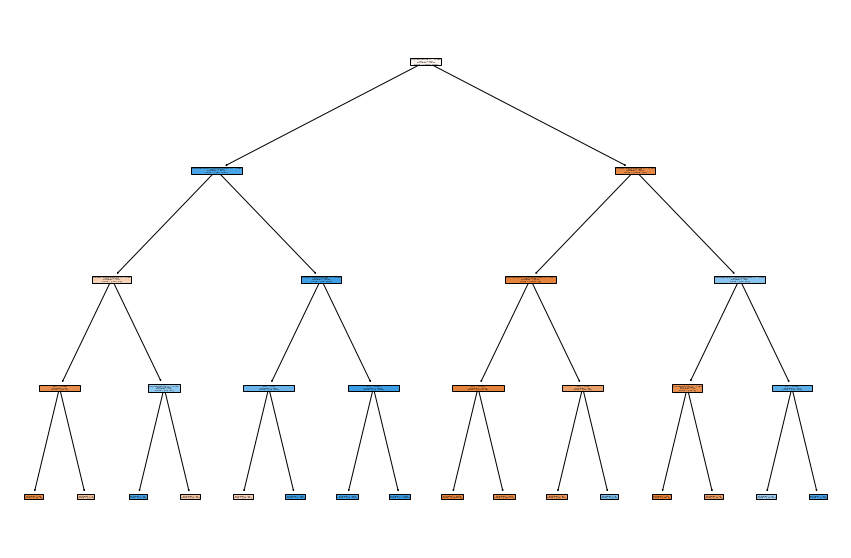

In [53]:
fig = plt.figure(figsize=(15, 10))
tree.plot_tree(clf, feature_names=X2_train.columns, filled=True)
fig.savefig("decistion_tree.png")

In [56]:
clex = ExtraTreeClassifier(random_state=0, max_depth=4)
clex.fit(X2_train, y2_train)
text_representation2 = tree.export_text(clex)
print(clex.score(X2_test, y2_test))
print('Accuracy: {:.2f}'.format(clex.score(X2_test, y2_test)))
print(text_representation2)

0.9555555555555556
Accuracy: 0.96
|--- feature_1 <= -1.16
|   |--- feature_0 <= 0.74
|   |   |--- feature_1 <= -1.23
|   |   |   |--- class: 1
|   |   |--- feature_1 >  -1.23
|   |   |   |--- feature_2 <= 0.04
|   |   |   |   |--- class: 1
|   |   |   |--- feature_2 >  0.04
|   |   |   |   |--- class: 1
|   |--- feature_0 >  0.74
|   |   |--- class: 1
|--- feature_1 >  -1.16
|   |--- feature_0 <= -0.33
|   |   |--- feature_0 <= -0.54
|   |   |   |--- feature_2 <= 0.74
|   |   |   |   |--- class: 0
|   |   |   |--- feature_2 >  0.74
|   |   |   |   |--- class: 1
|   |   |--- feature_0 >  -0.54
|   |   |   |--- feature_2 <= -0.03
|   |   |   |   |--- class: 0
|   |   |   |--- feature_2 >  -0.03
|   |   |   |   |--- class: 1
|   |--- feature_0 >  -0.33
|   |   |--- feature_2 <= -0.58
|   |   |   |--- feature_2 <= -1.06
|   |   |   |   |--- class: 0
|   |   |   |--- feature_2 >  -1.06
|   |   |   |   |--- class: 0
|   |   |--- feature_2 >  -0.58
|   |   |   |--- feature_1 <= 0.82
|   |   |

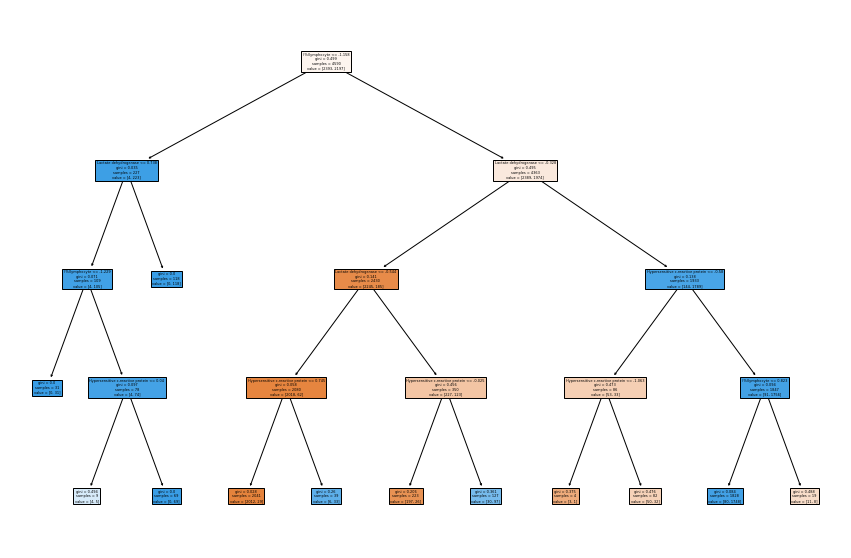

In [87]:
fig = plt.figure(figsize=(15, 10))
tree.plot_tree(clex, feature_names=X2_train.columns, filled=True)
fig.savefig("exdecistion_tree.png")

#Variables visualization

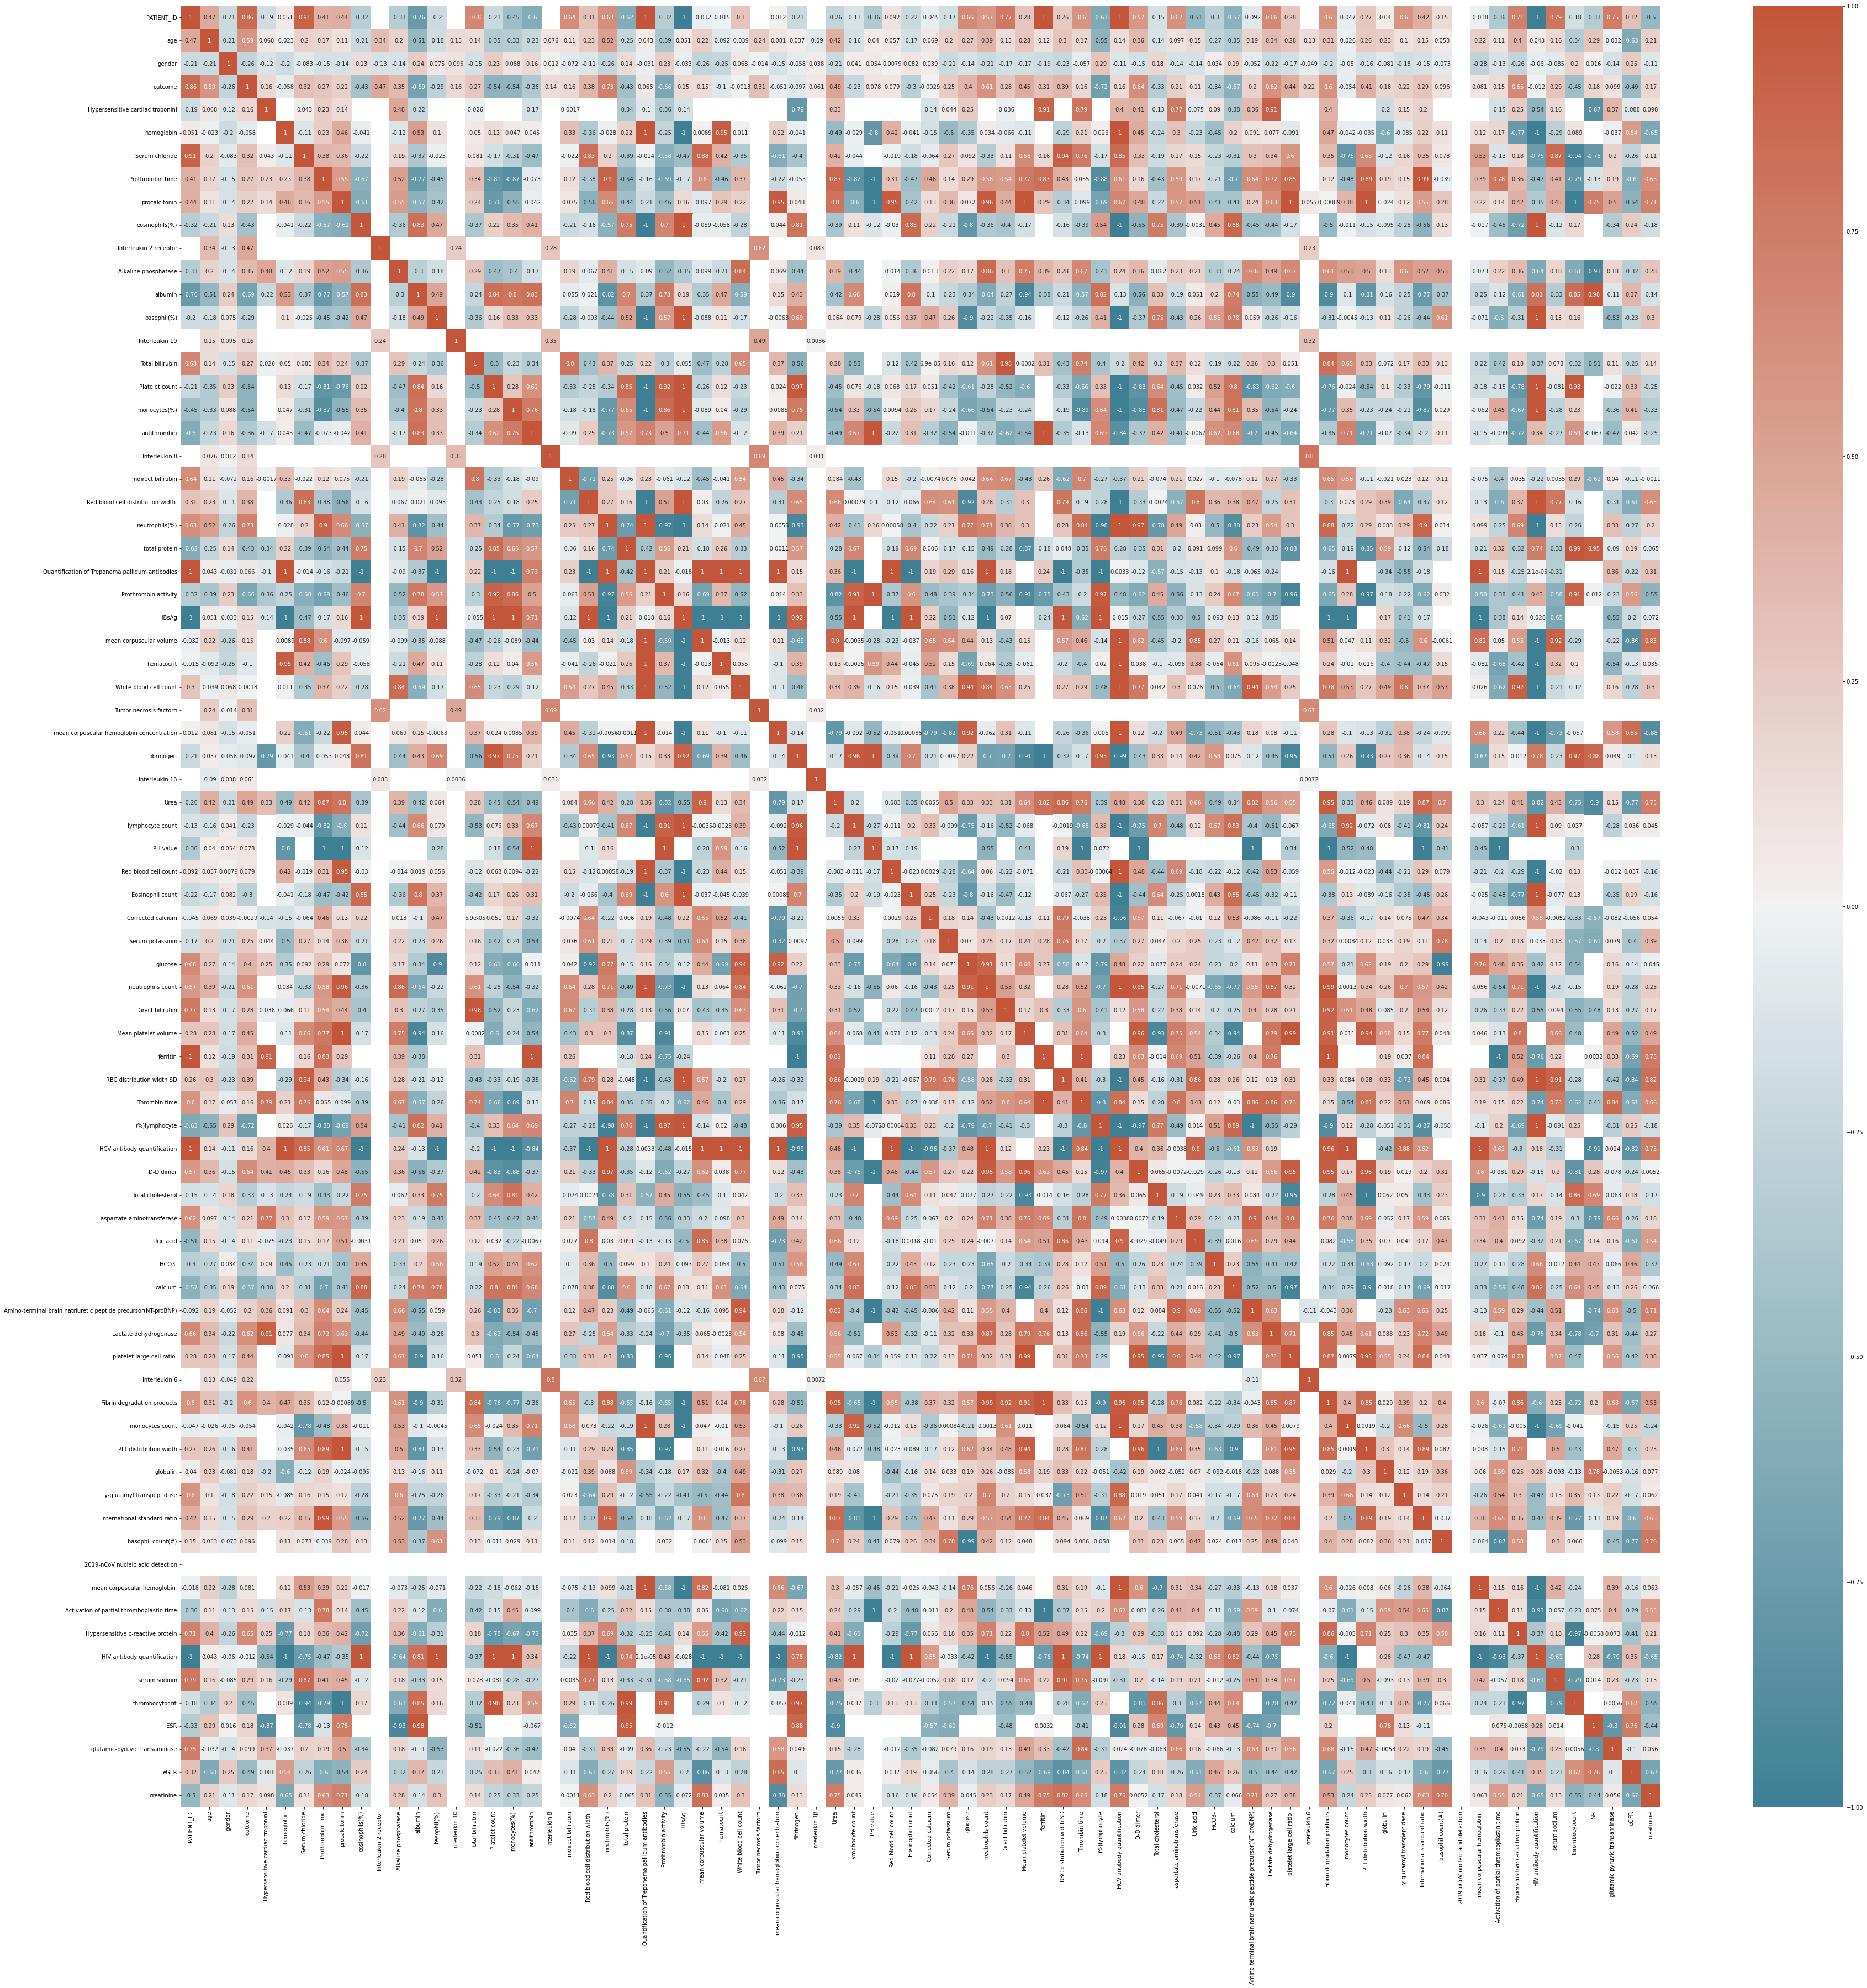

In [ ]:
# calculate correlation matrix
corr = train.corr()
# plot the heatmap
fig, ax = plt.subplots(figsize=(60,60))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True,ax=ax, cmap=sns.diverging_palette( 220, 20,as_cmap=True))
#high positive correlation between outcome and nerophils(%) 0,73 ; age 0,59 ; interleukin 2 receptor 0,47 ; urea 0,49 ; neurophilis count 0,61; D-D dimer 0,64
# Lactate dehydrogenase 0,62; Fibrin degeneration products 0,6; Hypersensitive c-reactive protein 0,65  

In [ ]:
print(train.info())

#High positive correlation 
Between outcome and nerophils(%) 0,73 ; age 0,59 ; interleukin 2 receptor 0,47 ; urea 0,49 ; neurophilis count 0,61; D-D dimer 0,64
Lactate dehydrogenase 0,62; Fibrin degeneration products 0,6; Hypersensitive c-reactive protein 0,65 

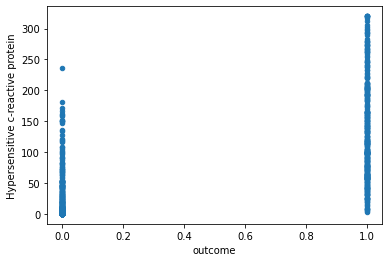

In [ ]:
train.plot(kind='scatter', x='outcome', y='Hypersensitive c-reactive protein')

<Figure size 432x288 with 0 Axes>

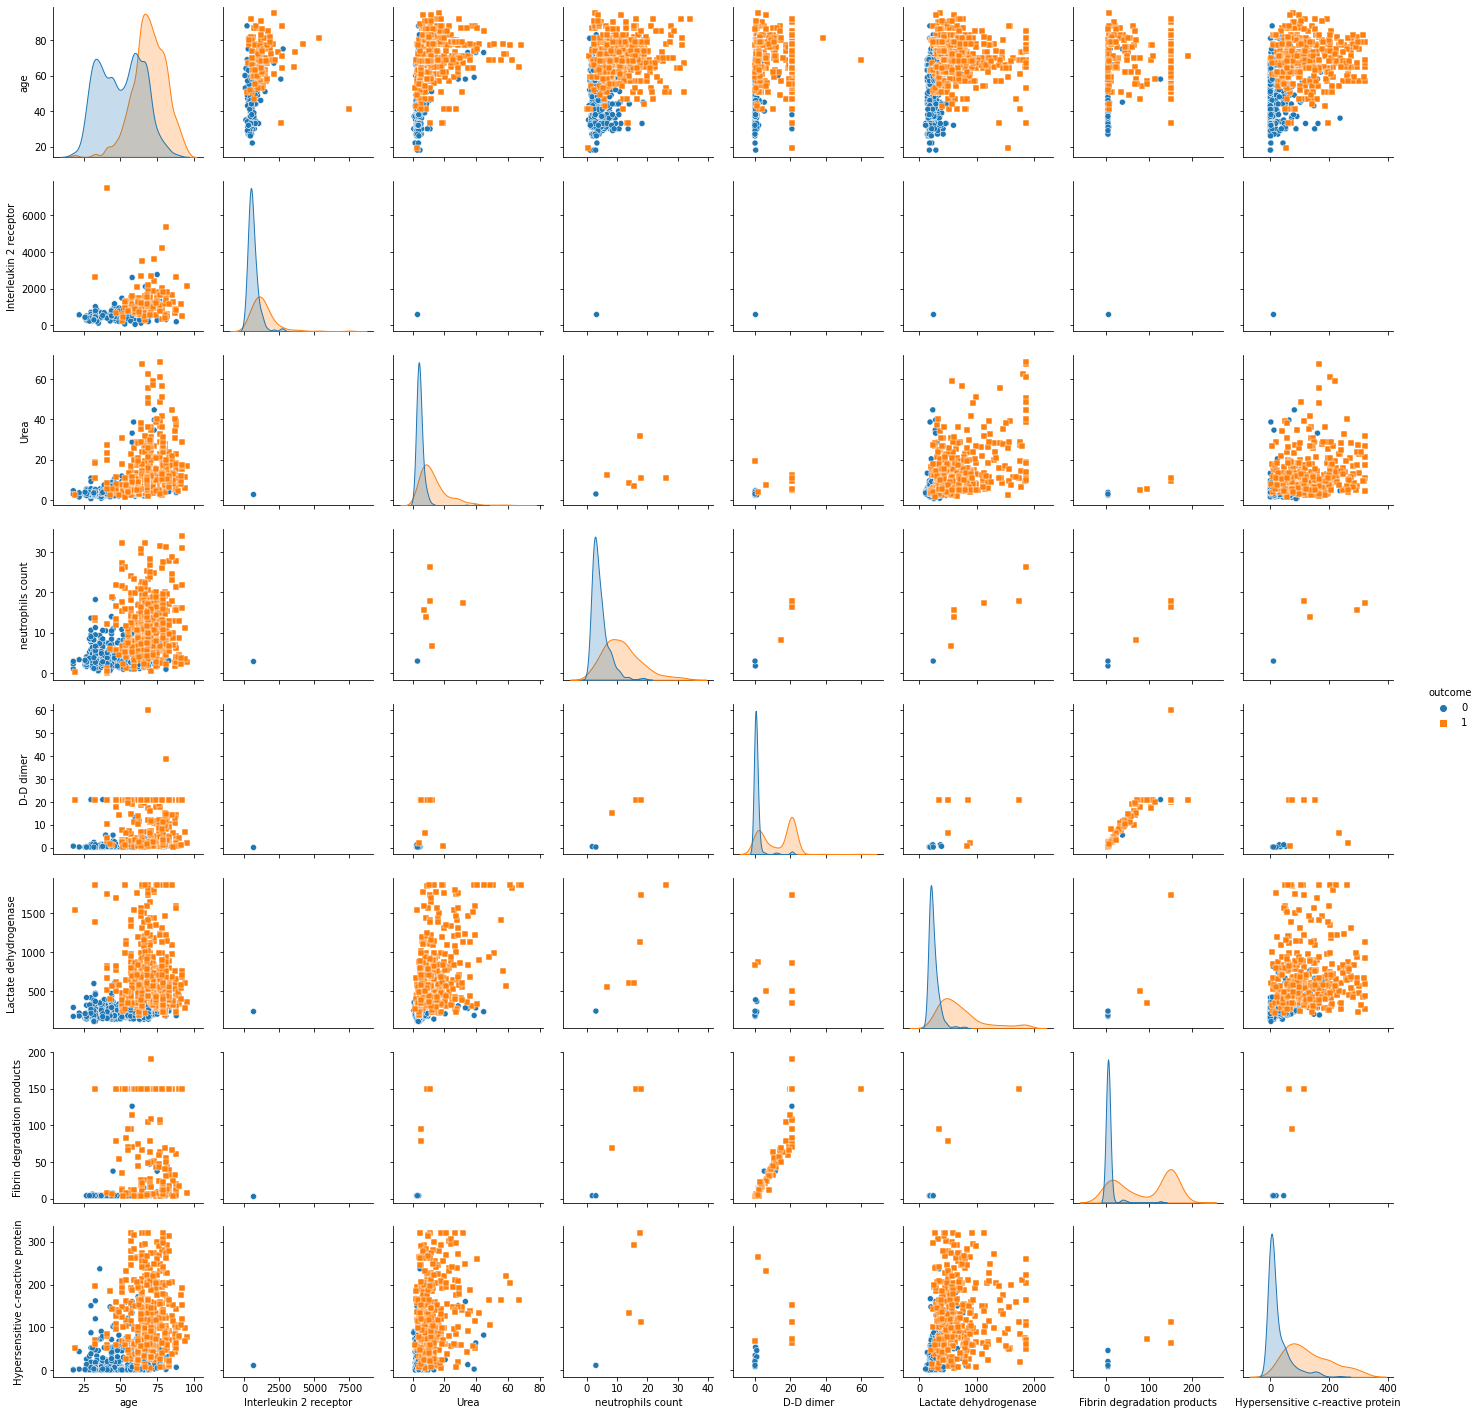

In [ ]:
#A closer look at detected variables
plt.figure()
sns.pairplot(train,vars = train.iloc[:,[1,10,34,42,50,57,60,70]], hue ="outcome", markers=["o", "s"])
plt.show()

#References
[1] D. C. Bindushree and V. U. Rani, "A review on using various DM techniques for evaluation of performance and analysis of heart disease prediction," 2017 International Conference On Smart Technologies For Smart Nation (SmartTechCon), 2017, pp. 686-690, doi: 10.1109/SmartTechCon.2017.8358459.

[2] https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions